In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import scipy.io as io
import keras_contrib
from PIL import Image
import zipfile
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from IPython import display
import datetime
import time
from tensorflow.keras.models import load_model

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:

model=tf.keras.applications.VGG19(input_shape=(256,256,3),weights='imagenet',include_top=False)
model.trainable=False
slice1=tf.keras.Sequential()
slice2=tf.keras.Sequential()
slice3=tf.keras.Sequential()
slice4=tf.keras.Sequential()
slice5=tf.keras.Sequential()

for i in range(4):
    slice1.add(model.layers[i])
for i in range(4,7):
    slice2.add(model.layers[i])
for i in range(7,12):
    slice3.add(model.layers[i])
for i in range(12,17):
    slice4.add(model.layers[i])
for i in range(17,22):
    slice5.add(model.layers[i])

model.trainable=False

In [4]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, w:, :]
    input_image = image[:, :w, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

In [5]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [6]:
# 目标尺寸
IMG_WIDTH = 256
IMG_HEIGHT = 256
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [7]:
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

In [8]:
# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

In [9]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [10]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [11]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
train_dataset = tf.data.Dataset.list_files('./data_opencountry/'+'*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)


In [12]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
test_dataset = tf.data.Dataset.list_files('./data_opencountry/'+'*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [13]:
def residual_block(filters,size):
    initializer=tf.random_normal_initializer(0,0.02)
    block=tf.keras.Sequential()
    block.add(tf.keras.layers.ZeroPadding2D(1))
    block.add(tf.keras.layers.Conv2D(filters,size,strides=1,padding='valid',kernel_initializer=initializer,use_bias=False))
    block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.LeakyReLU())
    block.add(tf.keras.layers.ZeroPadding2D(1))
    block.add(tf.keras.layers.Conv2D(filters,size,strides=1,padding='valid',kernel_initializer=initializer,use_bias=False))
    block.add(tf.keras.layers.BatchNormalization())
    
    return block

In [14]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
          tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                 kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [15]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [16]:
def Generator():
    initializer=tf.random_normal_initializer(0,0.02)
    inputs=tf.keras.layers.Input(shape=[256,256,3])#标签
    
    residual_blocks=[
        residual_block(512,3),
        residual_block(512,3),
        residual_block(512,3),
        residual_block(512,3),
        residual_block(512,3),
        residual_block(512,3),
        residual_block(512,3),
        residual_block(512,3),
        residual_block(512,3)
    ]
    
    x1=inputs
    x1=tf.keras.layers.ZeroPadding2D(3)(x1)
    x1=tf.keras.layers.Conv2D(64,7,strides=1,padding='valid',kernel_initializer=initializer,use_bias=False)(x1)
    x1=tf.keras.layers.BatchNormalization()(x1)
    x1=tf.keras.layers.LeakyReLU()(x1)
    
    #下采样 此时输入为（256，256，64）
    x1=tf.keras.layers.Conv2D(128,3,strides=2,padding='same',kernel_initializer=initializer,use_bias=False)(x1)#(128,128,128)
    x1=tf.keras.layers.BatchNormalization()(x1)
    x1_1=tf.keras.layers.LeakyReLU()(x1)
    x1=tf.keras.layers.Conv2D(256,3,strides=2,padding='same',kernel_initializer=initializer,use_bias=False)(x1_1)#(64,64,256)
    x1=tf.keras.layers.BatchNormalization()(x1)
    x1_2=tf.keras.layers.LeakyReLU()(x1)
    x1=tf.keras.layers.Conv2D(512,3,strides=2,padding='same',kernel_initializer=initializer,use_bias=False)(x1_2)#(32,32,512)
    x1=tf.keras.layers.BatchNormalization()(x1)
    x1=tf.keras.layers.LeakyReLU()(x1)
    x1_3=x1
    
    #残差
    for block in residual_blocks:
        x11=block(x1)
        x1=tf.add(x1,x11)
    #上采样此时（32，32，256）
    x1=tf.keras.layers.Concatenate()([x1_3, x1])
    x1=tf.keras.layers.Conv2DTranspose(256,3,strides=2,padding='same',kernel_initializer=initializer,use_bias=False)(x1)#(64,64,256)
    x1=tf.keras.layers.BatchNormalization()(x1)
    x1=tf.keras.layers.LeakyReLU()(x1)
    
    x1=tf.keras.layers.Concatenate()([x1_2, x1])
    x1=tf.keras.layers.Conv2DTranspose(128,3,strides=2,padding='same',kernel_initializer=initializer,use_bias=False)(x1)#(128,128,128)
    x1=tf.keras.layers.BatchNormalization()(x1)
    x1=tf.keras.layers.LeakyReLU()(x1)
    
    x1=tf.keras.layers.Concatenate()([x1_1, x1])
    x1=tf.keras.layers.Conv2DTranspose(64,3,strides=2,padding='same',kernel_initializer=initializer,use_bias=False)(x1)#(256,256,64)
    x1=tf.keras.layers.BatchNormalization()(x1)
    x1=tf.keras.layers.LeakyReLU()(x1)
    
    x1=tf.keras.layers.Conv2D(3,7,strides=1,padding='same',kernel_initializer=initializer,use_bias=False,activation='tanh')(x1)

    return tf.keras.Model(inputs=inputs,outputs=x1)

In [17]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [18]:
#generator=Generator()
#discriminator=Discriminator()

In [19]:
generator =load_model('./Generator_country720.h5')
discriminator = load_model('./Discriminator_country720.h5')

In [20]:
def vgg19_input(inputs):
    
    x1=slice1(inputs)
    x2=slice2(x1)
    x3=slice3(x2)
    x4=slice4(x3)
    x5=slice5(x4)
    return [x1,x2,x3,x4,x5]
    

In [21]:
LAMBDA = 2
def generator_loss(target,gen_dis_image,gen_image):#gen_image:(512,512,3) 
    gan_loss=tf.reduce_mean(1/2*tf.square(gen_dis_image-1))
    
    weight=[1/32,1/16,1/8,1/4,1]
    x_1=vgg19_input(gen_image)
    x_11=vgg19_input(target)
    l1_loss=tf.reduce_mean(tf.abs(gen_image-target))
    for i in range(len(x_1)):
        l1_loss=l1_loss+weight[i]*tf.reduce_mean(tf.abs(x_1[i]-x_11[i]))
    total_gen_loss=gan_loss+LAMBDA*l1_loss
    
    return total_gen_loss,l1_loss


In [22]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.reduce_mean(1/2*tf.square(disc_real_output-1))

    generated_loss = tf.reduce_mean(1/2*tf.square(disc_generated_output))

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


In [23]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4, beta_1=0.5)


In [24]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


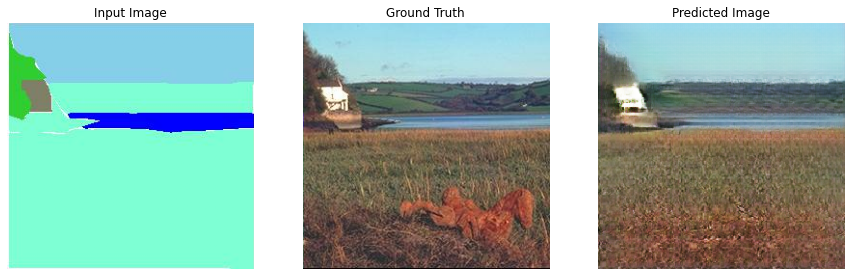

In [25]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)


In [26]:
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss,gen_l1_loss = generator_loss(target,disc_generated_output,gen_output)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))


In [28]:
def fit(train_ds, epochs, test_ds):
    num=410

    for epoch in range(721,epochs+3):
        
        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        print("\r总进度完成%.2f %%" % (epoch *100 /epochs), end="")
        print()
        # Train
        if (epoch!=0 and epoch%20==0 and epoch<=26) or (epoch!=0 and epoch%20==0 and epoch>26):
                    generator.save('./Generator_country%s.h5'%(epoch))
                    discriminator.save('./Discriminator_country%s.h5'%(epoch))
                    print(epoch)
        for n, (input_image, target) in train_ds.enumerate():
            print("\r子进度完成%.2f %%" % (n *100 /num), end="")
            time1 = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            
           # print('.', end='')
          #  if (n+1) % 100 == 0:
          #      print()
            train_step(input_image, target, epoch)
        print()


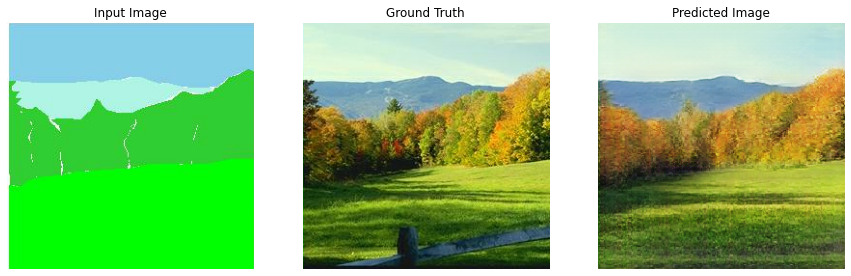

总进度完成84.60 %
子进度完成22.44 %

In [ ]:
EPOCHS = 1000
fit(train_dataset, EPOCHS, test_dataset)